In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install numpy torch matplotlib scipy tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 113.3 MB/s eta 0:00:00


## Imports

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from tqdm import tqdm
import os

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Loading

In [4]:
mat_path = '/content/drive/MyDrive/PINNs_BuckleyLeverett-main/Data/Buckley_Swc_0_Sor_0_M_2.mat'
data = loadmat(mat_path)

x_ref = data['x'].flatten()
t_ref = data['t'].flatten()
S_ref = data.get('S') or data.get('usol')
S_ref = S_ref.T if S_ref.shape[0] != x_ref.size else S_ref

x0, xL = x_ref.min(), x_ref.max()
t0, tF = t_ref.min(), t_ref.max()

## PINN model

In [5]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.model = nn.Sequential()
        for i in range(len(layers) - 1):
            lin = nn.Linear(layers[i], layers[i + 1])
            nn.init.xavier_uniform_(lin.weight)
            nn.init.zeros_(lin.bias)
            self.model.add_module(f"linear_{i}", lin)
            if i < len(layers) - 2:
                self.model.add_module(f"tanh_{i}", nn.Tanh())

    def forward(self, x):
        return self.model(x)

## Physics

In [6]:
M_val = 2.0
S_star = 0.618

def frac_flow(S):
    f_orig = M_val * S**2 / (M_val * S**2 + (1 - S)**2)
    sigma = (M_val * S_star**2) / (M_val * S_star**2 + (1 - S_star)**2) / S_star
    mask = (S < S_star).float()
    return mask * sigma * S + (1 - mask) * f_orig

def compute_pde_residual(model, X):
    X = X.clone().detach().to(device).requires_grad_(True)
    S_pred = model(X)
    grads = autograd.grad(S_pred, X, torch.ones_like(S_pred), create_graph=True)[0]
    S_x = grads[:, 0:1]
    S_t = grads[:, 1:2]
    f_pred = frac_flow(S_pred)
    gradf = autograd.grad(f_pred, X, torch.ones_like(f_pred), create_graph=True)[0]
    f_x = gradf[:, 0:1]
    residual = S_t + f_x
    return residual

## Data Preparation

In [9]:
N_ic = 150
x_ic = np.linspace(x0, xL, N_ic)
t_ic = np.zeros_like(x_ic)
S_ic = np.zeros_like(x_ic)

N_bc = 150
t_bc = np.linspace(t0, tF, N_bc)
x_bc = np.zeros_like(t_bc)
S_bc = np.ones_like(t_bc)

N_f = 10000
x_f = np.random.uniform(x0, xL, N_f)
t_f = np.random.uniform(t0, tF, N_f)
x_f = np.clip(x_f, 1e-5, None)
t_f = np.clip(t_f, 1e-5, None)

X_ic = torch.tensor(np.column_stack([x_ic, t_ic]), dtype=torch.float32).to(device)
S_ic_tensor = torch.tensor(S_ic, dtype=torch.float32).unsqueeze(1).to(device)

X_bc = torch.tensor(np.column_stack([x_bc, t_bc]), dtype=torch.float32).to(device)
S_bc_tensor = torch.tensor(S_bc, dtype=torch.float32).unsqueeze(1).to(device)

X_f = torch.tensor(np.column_stack([x_f, t_f]), dtype=torch.float32).to(device)

## Model setup

In [10]:
layers = [2, 50, 50, 50, 50, 1]
model = PINN(layers).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1500, gamma=0.5)

## Training

In [11]:
epochs = 500
rar_interval = 600
new_points = 500

for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    optimizer.zero_grad()

    S_pred_ic = model(X_ic)
    S_pred_bc = model(X_bc)
    residual = compute_pde_residual(model, X_f)

    loss_ic = nn.functional.mse_loss(S_pred_ic, S_ic_tensor)
    loss_bc = nn.functional.mse_loss(S_pred_bc, S_bc_tensor)
    loss_res = torch.mean(residual**2)

    loss = loss_ic + loss_bc + loss_res
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()

    if epoch % 1000 == 0 or epoch == 1:
        print(f"Epoch {epoch}, Loss: {loss.item():.6e}, Collocation points: {X_f.shape[0]}")

    if epoch % rar_interval == 0 and epoch < epochs:
        model.eval()
        candN = 50000
        x_cand = np.random.uniform(x0, xL, candN)
        t_cand = np.random.uniform(t0, tF, candN)
        x_cand = np.clip(x_cand, 1e-5, None)
        t_cand = np.clip(t_cand, 1e-5, None)

        X_cand = torch.tensor(np.column_stack([x_cand, t_cand]), dtype=torch.float32).to(device)
        res_vals = []

        with torch.no_grad():
            for i in range(0, candN, 10000):
                batch = X_cand[i:i+10000]
                res_batch = compute_pde_residual(model, batch)
                res_vals.append(res_batch.abs().cpu().numpy())

        res_cand = np.concatenate(res_vals, axis=0).flatten()
        top_idx = np.argpartition(res_cand, -new_points)[-new_points:]
        new_X = X_cand[top_idx].cpu()
        X_f = torch.cat([X_f.cpu(), new_X], dim=0).to(device)

        print(f"RAR: added {new_points} points, total collocation points: {X_f.shape[0]}")
        model.train()

  1%|          | 3/500 [00:00<00:41, 12.09it/s]

Epoch 1, Loss: 8.600355e-01, Collocation points: 10000


100%|██████████| 500/500 [00:28<00:00, 17.53it/s]


## Evaluation

In [12]:
model.eval()
xx, tt = np.meshgrid(x_ref, t_ref)
X_grid = torch.tensor(np.column_stack([xx.ravel(), tt.ravel()]), dtype=torch.float32).to(device)
batch_size = 10000
S_pred = []

with torch.no_grad():
    for i in range(0, X_grid.shape[0], batch_size):
        batch = X_grid[i:i+batch_size]
        S_pred.append(model(batch).cpu().numpy())

S_pred = np.concatenate(S_pred, axis=0).reshape(len(t_ref), len(x_ref))

if S_ref.shape != S_pred.shape and S_ref.T.shape == S_pred.shape:
    S_ref = S_ref.T

error = S_pred - S_ref
mse_error = np.mean(error**2)
rel_l2_error = np.linalg.norm(error) / np.linalg.norm(S_ref)

print(f"MSE error: {mse_error:.3e}")
print(f"Relative L2 error: {rel_l2_error:.3e}")

MSE error: 2.469e-03
Relative L2 error: 8.318e-02


## Model save

In [13]:
os.makedirs('/mnt/data', exist_ok=True)
torch.save(model.state_dict(), '/content/drive/MyDrive/PINNs_BuckleyLeverett-main/Data/PINN_BuckleyLeverett_Oleinik.pth')
print("Model and plots saved to /mnt/data/")

Model and plots saved to /mnt/data/


## Visuals

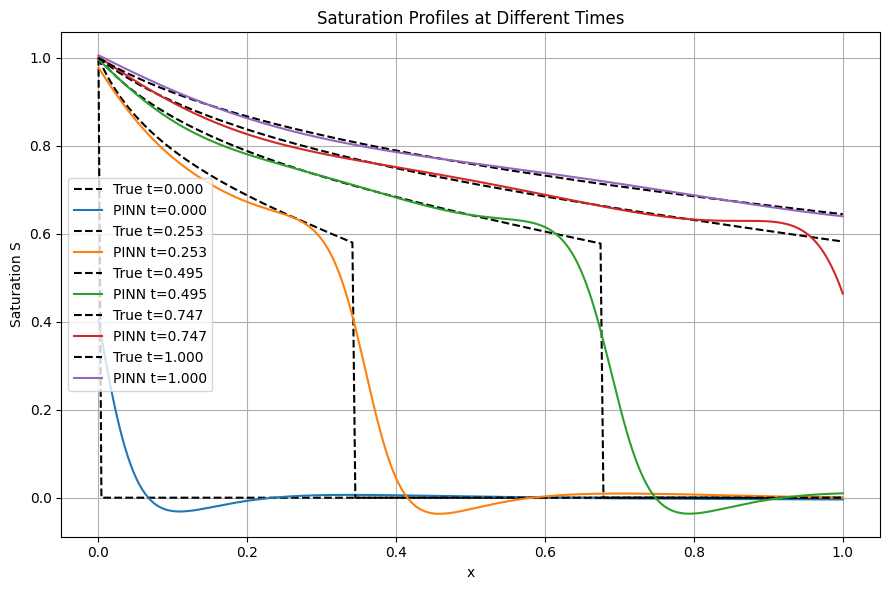

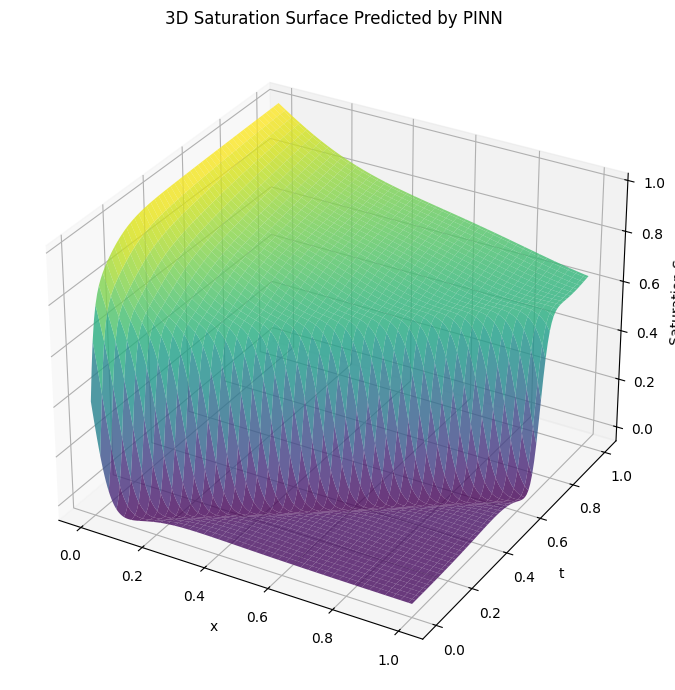

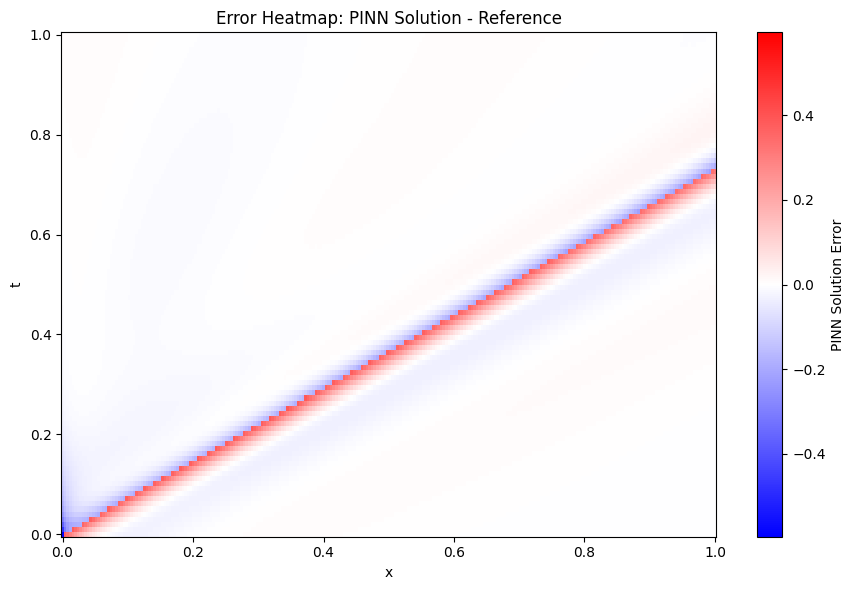

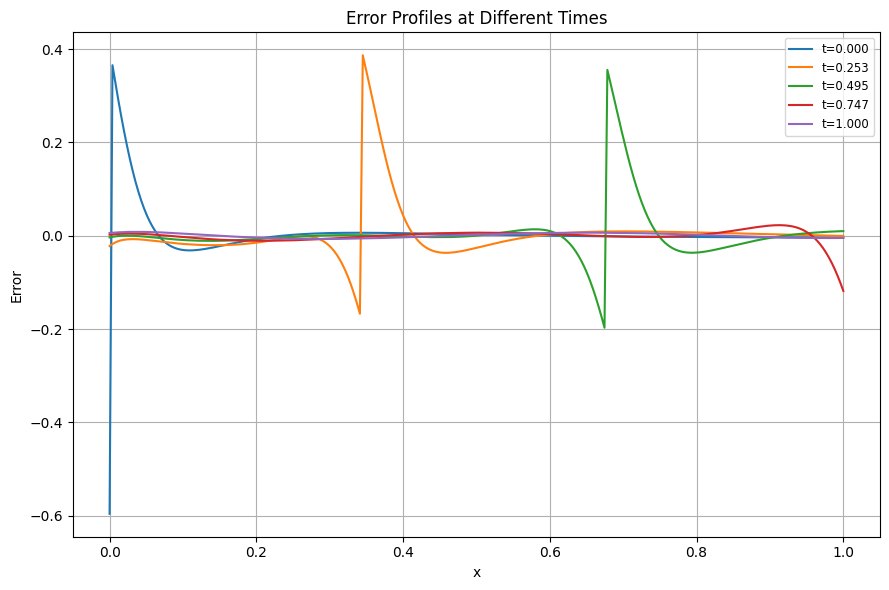

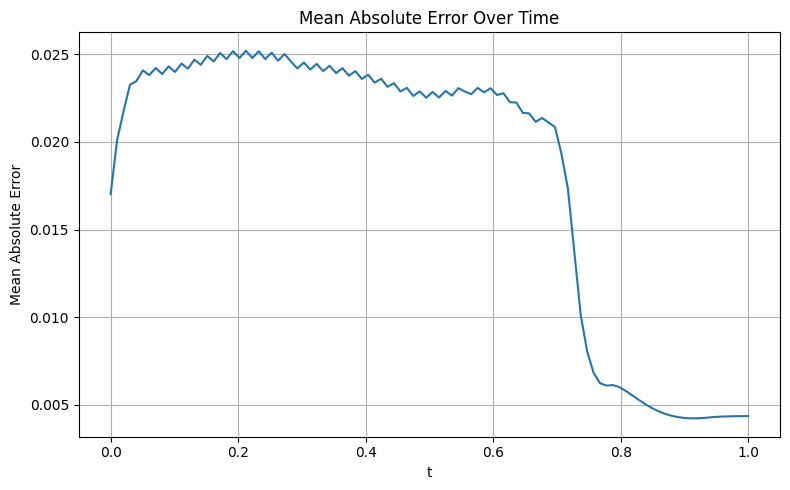

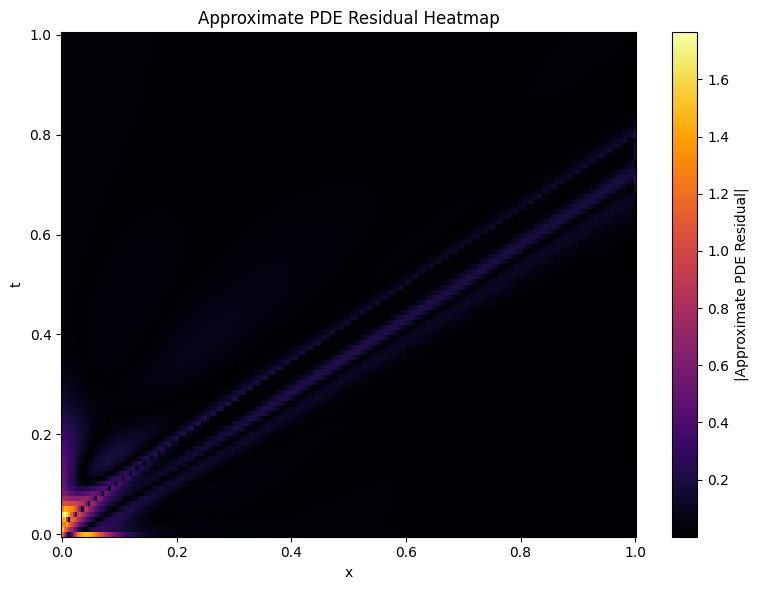

In [14]:
plt.figure(figsize=(9,6))
time_slices = [0.0, 0.25*tF, 0.5*tF, 0.75*tF, tF]

for t_val in time_slices:
    idx = np.argmin(np.abs(t_ref - t_val))
    plt.plot(x_ref, S_ref[idx, :], 'k--', label=f"True t={t_ref[idx]:.3f}")
    plt.plot(x_ref, S_pred[idx, :], label=f"PINN t={t_ref[idx]:.3f}")

plt.xlabel('x')
plt.ylabel('Saturation S')
plt.title('Saturation Profiles at Different Times')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/PINNs_BuckleyLeverett-main/Data/saturation_profile.png', dpi=300)
plt.show()

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, tt, S_pred, cmap='viridis', edgecolor='none', alpha=0.8)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('Saturation S')
ax.set_title('3D Saturation Surface Predicted by PINN')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/PINNs_BuckleyLeverett-main/Data/saturation_surface.png', dpi=300)
plt.show()

plt.figure(figsize=(9,6))
plt.pcolormesh(x_ref, t_ref, error, shading='auto',
               cmap='bwr', vmin=-np.max(np.abs(error)), vmax=np.max(np.abs(error)))
plt.colorbar(label='PINN Solution Error')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Error Heatmap: PINN Solution - Reference')
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
for t_val in time_slices:
    idx = np.argmin(np.abs(t_ref - t_val))
    plt.plot(x_ref, error[idx, :], label=f't={t_ref[idx]:.3f}')
plt.xlabel('x')
plt.ylabel('Error')
plt.title('Error Profiles at Different Times')
plt.legend(fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

mean_abs_error_time = np.mean(np.abs(error), axis=1)
plt.figure(figsize=(8,5))
plt.plot(t_ref, mean_abs_error_time)
plt.xlabel('t')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

dx = x_ref[1] - x_ref[0]
dt = t_ref[1] - t_ref[0]

S_x = np.gradient(S_pred, dx, axis=1)
S_t = np.gradient(S_pred, dt, axis=0)

def frac_flow_np(S):
    M = 2.0
    S_star = 0.618
    f_orig = M * S**2 / (M * S**2 + (1 - S)**2)
    sigma = (M * S_star**2) / (M * S_star**2 + (1 - S_star)**2) / S_star
    return np.where(S < S_star, sigma * S, f_orig)

f_pred = frac_flow_np(S_pred)
f_x = np.gradient(f_pred, dx, axis=1)

residual_approx = S_t + f_x

plt.figure(figsize=(8,6))
plt.pcolormesh(x_ref, t_ref, np.abs(residual_approx), shading='auto', cmap='inferno')
plt.colorbar(label='|Approximate PDE Residual|')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Approximate PDE Residual Heatmap')
plt.tight_layout()
plt.show()

## https://colab.research.google.com/drive/1TzeyIGlU8gWJ8tmf6EBGZIJkL_DVkEBs?usp=sharing